In [23]:
pip install swig

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install gym[box2d]

Note: you may need to restart the kernel to use updated packages.


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import gym
from IPython import display
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import deque


In [26]:


class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc_units=600, fc1_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)

        self.bn1 = nn.BatchNorm1d(fc_units)
        self.bn2 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu((self.bn1(self.fc1(state))))
        x = F.relu((self.bn2(self.fc2(x))))
        return F.torch.tanh(self.fc3(x))


class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=600, fcs2_units=300, fca1_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fcs2 = nn.Linear(fcs1_units, fcs2_units)
        self.fca1 = nn.Linear(action_size, fca1_units)
        self.fc1 = nn.Linear(fcs2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc1.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):


        xs = F.relu((self.bn1(self.fcs1(state))))
        xs = self.fcs2(xs)
        xa = self.fca1(action)
        x = F.relu(torch.add(xs, xa))
        return self.fc1(x)

In [27]:
import numpy as np
import copy
import random
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = 1000000
BATCH_SIZE = 100
GAMMA = 0.99
TAU = 0.001
LR_ACTOR = 0.0001
LR_CRITIC = 0.001
WEIGHT_DECAY = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():

    def __init__(self, state_size, action_size, random_seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)


        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.noise = OUNoise(action_size, random_seed)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            return self.learn(experiences, GAMMA)
        return None, None

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        return actor_loss.cpu().data.numpy(), critic_loss.cpu().data.numpy()

    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class OUNoise:

    def __init__(self, size, seed, mu=0., theta=0.4, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

In [28]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

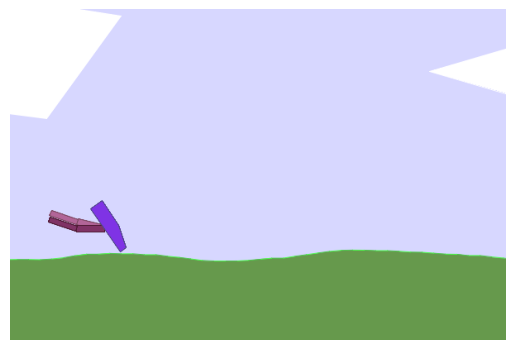

Episode: 1000/1000,	Mean Score: -47.17,	Mean Distance: 39.83,	actor_loss: -4.0777363777160645,	critic_loss:1.7629084587097168


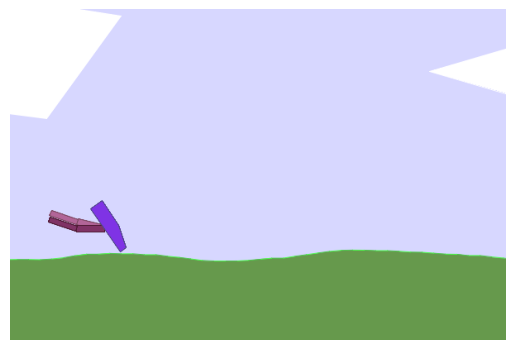

In [29]:

gym.logger.set_level(40)
env = gym.make('BipedalWalker-v3', render_mode="rgb_array")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

MAX_EPISODES = 1000
MAX_REWARD = 300
MAX_STEPS = 2000
MEAN_EVERY = 100

start_episode = 0

agent = Agent(state_size=state_dim, action_size=action_dim, random_seed=0)


scores = []
mean_scores = []
last_scores = deque(maxlen=MEAN_EVERY)
distances = []
mean_distances = []
last_distance = deque(maxlen=MEAN_EVERY)
losses_mean_episode = []

for ep in range(start_episode + 1, MAX_EPISODES + 1):
    state = env.reset()[0]

    total_reward = 0
    total_distance = 0
    actor_losses = []
    critic_losses = []
    for t in range(MAX_STEPS):
        if ep % 100 == 0:
            show_state(env)

        action = agent.act(state, noise)
        next_state, reward, done, _, info = env.step(action[0])
        actor_loss, critic_loss = agent.step(state, action, reward, next_state, done)
        if actor_loss is not None:
            actor_losses.append(actor_loss)
        if critic_loss is not None:
            critic_losses.append(critic_loss)
        state = next_state.squeeze()
        state = next_state
        total_reward += reward
        if reward != -100:
            total_distance += reward
        if done:
            break

    if len(actor_losses) >= 1 and len(critic_losses) >= 1:
        mean_loss_actor = np.mean(actor_losses)
        mean_loss_critic = np.mean(critic_losses)
        losses_mean_episode.append((ep, mean_loss_actor, mean_loss_critic))
    else:
        mean_loss_actor = None
        mean_loss_critic = None

    print(
        '\rEpisode: {}/{},\tScore: {:.2f},\tDistance: {:.2f},\tactor_loss: {},\tcritic_loss:{}'.format(ep, MAX_EPISODES,
                                                                                                       total_reward,
                                                                                                       total_distance,
                                                                                                       mean_loss_actor,
                                                                                                       mean_loss_critic),
        end="")

    scores.append(total_reward)
    distances.append(total_distance)
    last_scores.append(total_reward)
    last_distance.append(total_distance)
    mean_score = np.mean(last_scores)
    mean_distance = np.mean(last_distance)
    data = [ep, total_reward, total_distance, mean_loss_actor, mean_loss_critic]


        mean_scores.append(mean_score)
        mean_distances.append(mean_distance)
        print('\rEpisode: {}/{},\tMean Score: {:.2f},\tMean Distance: {:.2f},\tactor_loss: {},\tcritic_loss:{}'.format(
            ep, MAX_EPISODES,
            mean_score,
            mean_distance, mean_loss_actor,
            mean_loss_critic))
        data = [ep, mean_score, mean_distance, mean_loss_actor, mean_loss_critic]

env.close()
